## Keras

Keras это высокоуровневая обертка над tensorflow. Но в текущих реализациях библиотеке tf они живут очень рядом. 
Когда мы собираем свои нейронки мы берем уже готовые слои из keras и добавляем что-то свое, если нам требуется.
Но keras можно использовать без явного использования TF пытаясь свести задачу к fit-predict.


### Sequential
Самое простое, что мы можем сделать это собирать слои последовательно друг за другом - займемся же этим!

In [1]:
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Sequential, layers as L # подгружаем нужные модули. 
import tensorflow.keras as keras

import matplotlib.pyplot as plt

In [2]:
# в keras лежит несколько наборов данных. Для примера возьмем fashion_mnist - как mnist, но про предметы одежды :)
fashion_mnist = tf.keras.datasets.fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10**4, random_state=42)

X_train = X_train/ 255.
X_val = X_val/ 255.
X_test = X_test/ 255.

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [3]:
X_train[0,:,:].shape

(28, 28)

'Sandal'

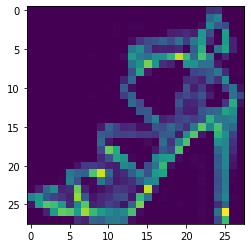

In [4]:
plt.imshow(X_train[0])
class_names[y_train[0]]

In [5]:
y_train

array([5, 0, 0, ..., 6, 6, 1], dtype=uint8)

In [6]:
# для того, чтобы учить через cross_entropy нам нужно сделать OHE таргетам. И эта функция есть в keras!
from tensorflow.keras.utils import to_categorical

y_train_ohe = to_categorical(y_train)
y_test_ohe = to_categorical(y_test)
y_val_ohe = to_categorical(y_val)


In [7]:
y_train_ohe

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [8]:
## Первая простая нейронка

tf.random.set_seed(42) # фиксируем random_seed

model = Sequential(name = 'first_model')
model.add(L.InputLayer(input_shape = (28,28))) # входной нейрон с данными. Его обычно можно опускать, сразу передавая 
# в нейрон размерность. Но Dense ячейки не умеют работать с картинками, поэтому оставляем Input
model.add(L.Flatten()) # разворачиваем картинку в вектор
model.add(L.Dense(100,  kernel_initializer='random_normal',name='First')) # можно именовать и потом брать слои по именам
model.add(L.ReLU()) # добавляем активацию
model.add(L.Dense(10, kernel_initializer = 'random_normal',name='Output'))
model.add(L.Softmax())
opt = keras.optimizers.Adam(learning_rate=1e-4) # так же нам нужно указать оптимайзер
model.compile(optimizer=opt,loss='categorical_crossentropy',
             metrics=["categorical_accuracy"]) # и собрать нашу модель, указав метрики,loss и оптимизатор


In [9]:
model.summary()

Model: "first_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
First (Dense)                (None, 100)               78500     
_________________________________________________________________
re_lu (ReLU)                 (None, 100)               0         
_________________________________________________________________
Output (Dense)               (None, 10)                1010      
_________________________________________________________________
softmax (Softmax)            (None, 10)                0         
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [10]:
history1 = model.fit(X_train,y_train_ohe,batch_size=500,epochs=2,validation_data = (X_val,y_val_ohe)) # и процесс обучения. Задаем количество эпох, размер батча и валидационную часть наших данных

Epoch 1/2
100/100 [==============================] - 2s 12ms/step - loss: 1.8981 - categorical_accuracy: 0.4697 - val_loss: 1.4741 - val_categorical_accuracy: 0.6431
Epoch 2/2
100/100 [==============================] - 1s 9ms/step - loss: 1.2028 - categorical_accuracy: 0.6653 - val_loss: 1.0262 - val_categorical_accuracy: 0.6838


In [11]:
#history1.params

In [12]:
#history1.history

In [13]:
#model.predict(X_val)

In [14]:
# Эту же модель можно записать чуть в меньшее количество строчек кода
model = Sequential(name = 'first_model')
model.add(L.InputLayer(input_shape = (28,28))) 
model.add(L.Flatten()) 
model.add(L.Dense(100,  kernel_initializer='random_normal',name='First',activation='relu')) # можно именовать и потом брать слои по именам
model.add(L.Dense(10, kernel_initializer = 'random_normal',name='Output',activation='softmax'))
opt = keras.optimizers.Adam(learning_rate=1e-4) 
model.compile(optimizer=opt,loss='categorical_crossentropy',
             metrics=["categorical_accuracy"]) 

history1 = model.fit(X_train,y_train_ohe,batch_size=500,epochs=2,validation_data = (X_val,y_val_ohe))


Epoch 1/2
100/100 [==============================] - 2s 11ms/step - loss: 1.8162 - categorical_accuracy: 0.4942 - val_loss: 1.4007 - val_categorical_accuracy: 0.6495
Epoch 2/2
100/100 [==============================] - 1s 10ms/step - loss: 1.1443 - categorical_accuracy: 0.6729 - val_loss: 0.9788 - val_categorical_accuracy: 0.6841


### Model

Класс Sequential позволяет набирать слои только последовательно.
Что же у нас есть новый герой  - Model.
Он позволяет собирать сетки практически любой архитектуры

In [15]:
from tensorflow.keras import Model  # подгружаем нужные модули. 

In [16]:
init = 'uniform'
act = 'relu'

input_tensor = L.Input(shape=(28, 28)) # задаем вход
x = L.Flatten()(input_tensor)# применение нейрона к входу
x = L.Dense(100, kernel_initializer=init, activation=act)(x) # повторяем всю логику сколько нам надо
x = L.Dense(100, kernel_initializer=init, activation=act)(x)
output_tensor = L.Dense(10, kernel_initializer=init, activation='softmax')(x)

model = keras.Model(input_tensor, output_tensor) # Keras под копотом сам собирает граф.
# Если он может получить из входа выхода то вы великолепны.

model.compile(optimizer=opt,loss='categorical_crossentropy',
             metrics=["categorical_accuracy"]) 

In [17]:
history = model.fit(X_train,y_train_ohe,batch_size=500,epochs=2,validation_data = (X_val,y_val_ohe))

Epoch 1/2
100/100 [==============================] - 2s 13ms/step - loss: 1.7175 - categorical_accuracy: 0.4992 - val_loss: 1.1117 - val_categorical_accuracy: 0.6157
Epoch 2/2
100/100 [==============================] - 1s 10ms/step - loss: 0.9294 - categorical_accuracy: 0.6556 - val_loss: 0.8372 - val_categorical_accuracy: 0.6664


### Несколько входов

Такой подход позволяет делать практически любой гибкости нейронки. Как пример - нейрона, принимающая два входа

In [18]:
input_1 = L.Input(shape=(28, 28))
input_2 = L.Input(shape=(28, 28))

x1 = L.Flatten()(input_1)
x1 = L.Dense(100, kernel_initializer=init, activation=act)(x1)
x1 = L.Dense(100, kernel_initializer=init, activation=act)(x1)

x2 = L.Flatten()(input_2)
x2 = L.Dense(100, kernel_initializer=init, activation=act)(x2)
x2 = L.Dense(100, kernel_initializer=init, activation=act)(x2)

x = L.concatenate([x1, x2]) # Волшебное слово, которое позволяет нам соеденять несколько потоков наших данных
output = L.Dense(10, kernel_initializer=init, activation='softmax')(x)

model = keras.Model([input_1, input_2], output)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 784)          0           input_4[0][0]                    
__________________________________________________________________________________________________
flatten_4 (Flatten)             (None, 784)          0           input_5[0][0]                    
____________________________________________________________________________________________

In [19]:
model.compile(optimizer=opt,loss='categorical_crossentropy',
             metrics=["categorical_accuracy"]) 

In [20]:
history = model.fit([X_train,X_train],y_train_ohe,batch_size=500,epochs=2,validation_data = ([X_val,X_val],y_val_ohe))

Epoch 1/2
100/100 [==============================] - 3s 21ms/step - loss: 1.3890 - categorical_accuracy: 0.5688 - val_loss: 0.8389 - val_categorical_accuracy: 0.6807
Epoch 2/2
100/100 [==============================] - 2s 17ms/step - loss: 0.7304 - categorical_accuracy: 0.7328 - val_loss: 0.6778 - val_categorical_accuracy: 0.7556


In [21]:
# нужно для винды, если не видит путь до graphviz
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
from tensorflow.keras.utils import plot_model


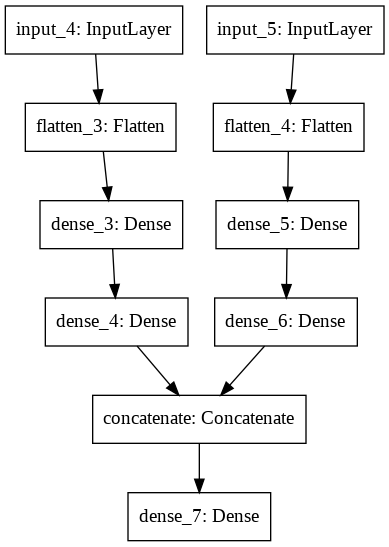

In [22]:
plot_model(model) # можно нарисовать модельку

### Несколько выходов и функций потерь

In [23]:
init = 'uniform'
act = 'relu'

input_tensor = L.Input(shape=(28, 28))

x = L.Flatten()(input_tensor)
x1 = L.Dense(100, kernel_initializer=init, activation=act)(x)
x2 = L.Dense(100, kernel_initializer=init, activation=act)(x)
x3 = L.Dense(100, kernel_initializer=init, activation=act)(x)

output_1 = L.Dense(1, kernel_initializer=init, activation='sigmoid',name='gender')(x1)
output_2 = L.Dense(10, kernel_initializer=init, activation='softmax',name='income')(x2)
output_3 = L.Dense(1, kernel_initializer=init,name='age')(x3)

model = keras.Model(input_tensor, [output_1, output_2, output_3])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
flatten_5 (Flatten)             (None, 784)          0           input_6[0][0]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 100)          78500       flatten_5[0][0]                  
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 100)          78500       flatten_5[0][0]                  
____________________________________________________________________________________________

In [24]:
# чтобы модель не переобучилась под самую большую функцию потерь
# их можно взвесить
model.compile(optimizer='adam', loss=['mse', 'categorical_crossentropy', 'binary_crossentropy'],
                                    loss_weights=[0.25, 1., 10.])


# если дали выходам имена, можно вот так: 

model.compile(optimizer='adam',

              loss={'age': 'mse',
                    'income': 'categorical_crossentropy',
                    'gender': 'binary_crossentropy'},
                    
              loss_weights={'age': 0.25,
                            'income': 1.,
                            'gender': 10.})

### Callbacks

In [25]:
from tensorflow.keras import callbacks
 
class My_Callback(callbacks.Callback):     # Класс My_Callback унаследовал свойства класса Callback
    def on_train_begin(self, logs={}):           # Функция, которая выполняется в начале обучения 
        return
 
    def on_train_end(self, logs={}):             # Функция, которая выполняется в конце обучения 
        return
 
    def on_epoch_begin(self, logs={}):           # В начале каждой эпохи 
        return
 
    def on_epoch_end(self, epoch, logs={}): 
        # В конце каждой эпохи
        return
 
    def on_batch_begin(self, batch, logs={}):    # В начале батча
        return
 
    def on_batch_end(self, batch, logs={}):      # В конце батча 
        return

В keras уже есть несколько удобных callback:

In [26]:
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler,ReduceLROnPlateau,ModelCheckpoint

In [27]:
EarlyStopping # останавливает обучение если наша метрика не меняет n эпох
LearningRateScheduler # меняет наш learning_rate по расписанию
ReduceLROnPlateau # понижает на LR если не происходит улучшения
ModelCheckpoint # сохраняет нашу лучшую модель

tensorflow.python.keras.callbacks.ModelCheckpoint

In [28]:
early_stop = EarlyStopping(patience=3)
reduce_on_plateau = ReduceLROnPlateau(patience=3)
# filepath="./weights-improvement-{epoch:02d}-{val_categorical_accuracy:.2f}.hdf5"
filepath="./weights-improvement.hdf5"
model_checkpoing = ModelCheckpoint(filepath,
                                   save_best_only=True,
                                  save_weights_only=True)

In [29]:
def create_simple_model():
    model = Sequential(name = 'simple_model')
    model.add(L.InputLayer(input_shape = (28,28))) 
    model.add(L.Flatten()) 
    model.add(L.Dense(100,  kernel_initializer='random_normal',name='First',activation='relu'))
    model.add(L.Dense(100,  kernel_initializer='random_normal',name='Second',activation='relu'))
    model.add(L.Dense(10, kernel_initializer = 'random_normal',name='Output',activation='softmax'))
    opt = keras.optimizers.Adam(learning_rate=1e-4) 
    model.compile(optimizer=opt,loss='categorical_crossentropy',
                 metrics=["categorical_accuracy"]) 
    return model


In [30]:
model = create_simple_model()

history = model.fit(X_train,y_train_ohe,batch_size=500,epochs=10,
                     validation_data = (X_val,y_val_ohe),
                    callbacks = [early_stop,reduce_on_plateau,model_checkpoing])


Epoch 1/10
100/100 [==============================] - 2s 11ms/step - loss: 2.0177 - categorical_accuracy: 0.5125 - val_loss: 1.5727 - val_categorical_accuracy: 0.6368
Epoch 2/10
100/100 [==============================] - 1s 11ms/step - loss: 1.1925 - categorical_accuracy: 0.6537 - val_loss: 0.9608 - val_categorical_accuracy: 0.6664
Epoch 3/10
100/100 [==============================] - 1s 9ms/step - loss: 0.8469 - categorical_accuracy: 0.6908 - val_loss: 0.7866 - val_categorical_accuracy: 0.7060
Epoch 4/10
100/100 [==============================] - 1s 9ms/step - loss: 0.7232 - categorical_accuracy: 0.7393 - val_loss: 0.6996 - val_categorical_accuracy: 0.7498
Epoch 5/10
100/100 [==============================] - 1s 11ms/step - loss: 0.6509 - categorical_accuracy: 0.7718 - val_loss: 0.6417 - val_categorical_accuracy: 0.7788
Epoch 6/10
100/100 [==============================] - 1s 10ms/step - loss: 0.6017 - categorical_accuracy: 0.7929 - val_loss: 0.5990 - val_categorical_accuracy: 0.7968


In [31]:
model.load_weights('./weights-improvement.hdf5')

In [32]:
#Сохранение целой модели
filepath="./full_model_improvement.hdf5"
model_checkpoing = ModelCheckpoint(filepath,
                                   save_best_only=True,
                                  save_weights_only=False)
simple_model = create_simple_model()

history = simple_model.fit(X_train,y_train_ohe,batch_size=500,epochs=10,
                     validation_data = (X_val,y_val_ohe),
                    callbacks = [early_stop,reduce_on_plateau,model_checkpoing])


Epoch 1/10
100/100 [==============================] - 1s 11ms/step - loss: 1.9862 - categorical_accuracy: 0.4591 - val_loss: 1.5363 - val_categorical_accuracy: 0.6423
Epoch 2/10
100/100 [==============================] - 1s 9ms/step - loss: 1.1686 - categorical_accuracy: 0.6707 - val_loss: 0.9333 - val_categorical_accuracy: 0.6934
Epoch 3/10
100/100 [==============================] - 1s 9ms/step - loss: 0.8152 - categorical_accuracy: 0.7263 - val_loss: 0.7524 - val_categorical_accuracy: 0.7377
Epoch 4/10
100/100 [==============================] - 1s 10ms/step - loss: 0.6867 - categorical_accuracy: 0.7647 - val_loss: 0.6649 - val_categorical_accuracy: 0.7692
Epoch 5/10
100/100 [==============================] - 1s 10ms/step - loss: 0.6167 - categorical_accuracy: 0.7890 - val_loss: 0.6109 - val_categorical_accuracy: 0.7907
Epoch 6/10
100/100 [==============================] - 1s 11ms/step - loss: 0.5717 - categorical_accuracy: 0.8056 - val_loss: 0.5710 - val_categorical_accuracy: 0.8049


In [33]:
simple_model = keras.models.load_model(filepath)

In [34]:
simple_model.evaluate(x=X_val,y=y_val_ohe, batch_size=500)

20/20 [==============================] - 0s 4ms/step - loss: 0.4957 - categorical_accuracy: 0.8306


[0.4956892132759094, 0.8306000232696533]

In [35]:
from tensorflow.keras import callbacks

class Printlogs(callbacks.Callback):

    def on_epoch_end(self, epoch, logs):
        if epoch % 3 == 0:
            print(logs)
        

In [36]:
simple_model = create_simple_model()
our_callback = Printlogs()

In [37]:
history = simple_model.fit(X_train,y_train_ohe,batch_size=500,epochs=10,
                     validation_data = (X_val,y_val_ohe),
                    callbacks = [our_callback],
                           verbose=1)

Epoch 1/10
100/100 [==============================] - 2s 13ms/step - loss: 2.0496 - categorical_accuracy: 0.4549 - val_loss: 1.6658 - val_categorical_accuracy: 0.5527
{'loss': 2.049647808074951, 'categorical_accuracy': 0.4548799991607666, 'val_loss': 1.6658072471618652, 'val_categorical_accuracy': 0.5526999831199646}
Epoch 2/10
100/100 [==============================] - 1s 9ms/step - loss: 1.2792 - categorical_accuracy: 0.6426 - val_loss: 1.0161 - val_categorical_accuracy: 0.6717
Epoch 3/10
100/100 [==============================] - 1s 11ms/step - loss: 0.8822 - categorical_accuracy: 0.7002 - val_loss: 0.8084 - val_categorical_accuracy: 0.7165
Epoch 4/10
100/100 [==============================] - 1s 10ms/step - loss: 0.7364 - categorical_accuracy: 0.7448 - val_loss: 0.7083 - val_categorical_accuracy: 0.7555
{'loss': 0.7363570928573608, 'categorical_accuracy': 0.7448199987411499, 'val_loss': 0.7083086967468262, 'val_categorical_accuracy': 0.7555000185966492}
Epoch 5/10
100/100 [========

In [38]:
import numpy as np
# Напишем кастомное изменение скорости обучения
INIT_LR=0.1
# Стратегия для понижения скорости
def lr_scheduler(epoch):
    drop = 0.5
    epochs_drop = 1.0
    lrate = INIT_LR * np.math.pow(drop, np.math.floor((epoch)/epochs_drop))
    return lrate
lrate = LearningRateScheduler(lr_scheduler)

# класс чтобы отслеживать бесчинства
class Print_lr(callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print(float(tf.keras.backend.get_value(self.model.optimizer.lr)))
        # чтобы установить свой LR надо указать
        # LR_OUR = ....
        # tf.keras.backend.set_value(self.model.optimizer.lr, LR_OUR)


simple_model = create_simple_model()
history = simple_model.fit(X_train,y_train_ohe,batch_size=500,epochs=20,
                     validation_data = (X_val,y_val_ohe),
                    callbacks = [lrate,Print_lr()],
                           verbose=0)


0.10000000149011612
0.05000000074505806
0.02500000037252903
0.012500000186264515
0.0062500000931322575
0.0031250000465661287
0.0015625000232830644
0.0007812500116415322
0.0003906250058207661
0.00019531250291038305
9.765625145519152e-05
4.882812572759576e-05
2.441406286379788e-05
1.220703143189894e-05
6.10351571594947e-06
3.051757857974735e-06
1.5258789289873675e-06
7.629394644936838e-07
3.814697322468419e-07
1.9073486612342094e-07


### Кастомные loss и метрики
Что уже есть
https://keras.io/api/metrics/

https://keras.io/api/losses/

In [39]:
celsius    = np.array([-40, -10,  0,  8, 15, 22,  38],  dtype=float)
fahrenheit = np.array([-40,  14, 32, 46, 59, 72, 100],  dtype=float)

In [40]:


model = Sequential()
model.add(L.Dense(1))

opt = tf.keras.optimizers.Adam( )

model.compile(loss='mse', optimizer=opt)
model.fit(celsius, fahrenheit,  epochs=3, verbose=1)



Epoch 1/3
1/1 [==============================] - 1s 539ms/step - loss: 1129.5472
Epoch 2/3
1/1 [==============================] - 0s 13ms/step - loss: 1128.9039
Epoch 3/3
1/1 [==============================] - 0s 18ms/step - loss: 1128.2617


In [41]:
def custom_loss_function(y_true, y_pred):
    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=-1)

In [42]:
%%time
model = Sequential()
model.add(L.Dense(1))

opt = tf.keras.optimizers.Adam( )

model.compile(loss=custom_loss_function, optimizer=opt)
model.fit(celsius, fahrenheit,  epochs=3,verbose=1)



Epoch 1/3
1/1 [==============================] - 1s 722ms/step - loss: 1123.1088
Epoch 2/3
1/1 [==============================] - 0s 9ms/step - loss: 1122.4781
Epoch 3/3
1/1 [==============================] - 0s 12ms/step - loss: 1121.8488
CPU times: user 741 ms, sys: 33.8 ms, total: 775 ms
Wall time: 897 ms


In [43]:
## тоже самое можно делать и с метриками. Также можно следить сразу за несколькими метриками, что бывает полезно.
## Если хотим добавить совсем сложную логику то мы это будем делать через callback

В этой тетрадке немного поработаем с градусами по цельсию и фаренгейту! Снова попробуем восстановить формулу 

$$ f = c \times 1.8 + 32 $$

In [44]:

model = Sequential()
model.add(L.Dense(1,name='our_neural'))
opt = tf.keras.optimizers.Adam(0.1)

model.compile(loss='mse', optimizer=opt)
model.fit(celsius, fahrenheit,  epochs=600, verbose=0)



In [45]:
## элементарная задача, но из-за того, что данные не скалированы сходились вечность
our_layer = model.get_layer(name='our_neural')
our_layer.variables

[<tf.Variable 'our_neural/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[1.8124708]], dtype=float32)>,
 <tf.Variable 'our_neural/bias:0' shape=(1,) dtype=float32, numpy=array([30.270817], dtype=float32)>]

In [46]:
our_layer(np.array(celsius).reshape((7,1))) ## Берем прогнозы от слоя

<tf.Tensor: shape=(7, 1), dtype=float32, numpy=
array([[-42.228016],
       [ 12.146109],
       [ 30.270817],
       [ 44.770584],
       [ 57.45788 ],
       [ 70.14517 ],
       [ 99.144714]], dtype=float32)>

Есть понимание, как определить в callback на какой эпохе мы получили правильное значение весов?

### Пишем класс нейронки с TF и keras вместе

In [47]:
# транспонировали выборку
x_train = celsius[:,None]
y_train = fahrenheit[:,None]

In [48]:
class our_NN(Model):
    
    def __init__(self, n_hidden_neurons):
        super(our_NN, self).__init__()
        self.fc1 = L.Dense(n_hidden_neurons, kernel_initializer='glorot_uniform', activation='relu')
        self.fc2 = L.Dense(n_hidden_neurons, kernel_initializer='glorot_uniform')

    def encode(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [49]:
model = our_NN(1)
model.encode(x_train)

<tf.Tensor: shape=(7, 1), dtype=float32, numpy=
array([[-7.8508096],
       [-1.9627024],
       [ 0.       ],
       [ 0.       ],
       [ 0.       ],
       [ 0.       ],
       [ 0.       ]], dtype=float32)>

In [50]:
# Ошибка для модели
def mean_square(y_pred, y_true):
    return tf.reduce_mean((y_pred-y_true)**2)

# оптимизатор 
optimizer = tf.optimizers.SGD(learning_rate=0.001)

# процесс оптимизации
def model_train(X, Y):

    # находим loss и пробрасываем градиент
    with tf.GradientTape() as g:
        pred = model.encode(X)
        loss = mean_square(pred, Y)

    # Вычисляем градиенты
    gradients = g.gradient(loss, model.variables)
    
    # Обновляем веса a и b в ходе одной итерации спуска 
    optimizer.apply_gradients(zip(gradients, model.variables))

In [51]:
#Обучение
epochs = 1000 # число эпох 

for i in range(epochs):
    
    # Делаем щаг градиентного спуска 
    model_train(x_train, y_train)
    
    # Каждую сотую итерацию следим за тем, что произошло
    if i%100 == 0:
        y_pred = model.encode(x_train)
        loss_val = mean_square(y_pred, y_train)
        print("step: %i, loss: %f" % (i, loss_val))

step: 0, loss: 3244.799561
step: 100, loss: 2442.354980
step: 200, loss: 1901.183594
step: 300, loss: 1507.917725
step: 400, loss: 1222.283081
step: 500, loss: 1014.504395
step: 600, loss: 862.869995
step: 700, loss: 751.803162
step: 800, loss: 670.177185
step: 900, loss: 655.715637


#  Свой слой на Tensorflow для Keras

Новые слои можно писать на основе керасовского класса `Layer`. Если прописать `help(tf.keras.layers.Layer)`, можно почитать про него. Если в кратце, нужно реализовать три части: 

* Конструктор, в нём мы описываем гиперпараметры 
* Метод `build`, в которм мы описываем все переменные 
* Метод `call`, который делает forward pass

In [52]:
class MyLinear(L.Layer):
    
    # Задаём консруктор 
    def __init__(self, units=32):
        super(MyLinear, self).__init__()  # чтобы коректно унаследовались методы
        self.units = units                # число нейронов

    def build(self, input_shape):
        # add_weight внутри build то же самое что и Variable, но совместимо с Keras
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal', 
                                 trainable=True)
        
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='random_normal', 
                                 trainable=True)

    # Применение 
    def call(self, inputs):
        # сразу делаем и линейное преобразование и ReLU (а почему бы и нет)
        return tf.nn.relu(tf.matmul(inputs, self.w) + self.b) 

In [53]:
model_custom = Sequential(name = 'simple_model')
model_custom.add(L.InputLayer(input_shape = (28,28))) 
model_custom.add(L.Flatten()) 
model_custom.add(L.Dense(100,  kernel_initializer='random_normal',name='First',activation='relu'))
model_custom.add(MyLinear()) ### Самый красивый слой
model_custom.add(L.Dense(10, kernel_initializer = 'random_normal',name='Output',activation='softmax'))
opt = keras.optimizers.Adam(learning_rate=1e-4) 
model_custom.compile(optimizer=opt,loss='categorical_crossentropy',
             metrics=["categorical_accuracy"]) 

In [54]:
history = model_custom.fit(X_train,y_train_ohe,batch_size=500,epochs=10,
                     validation_data = (X_val,y_val_ohe),
                    callbacks = [early_stop,reduce_on_plateau],verbose=1)

Epoch 1/10
100/100 [==============================] - 2s 12ms/step - loss: 2.1586 - categorical_accuracy: 0.3236 - val_loss: 1.9475 - val_categorical_accuracy: 0.4620
Epoch 2/10
100/100 [==============================] - 1s 10ms/step - loss: 1.6320 - categorical_accuracy: 0.5456 - val_loss: 1.3348 - val_categorical_accuracy: 0.5834
Epoch 3/10
100/100 [==============================] - 1s 10ms/step - loss: 1.1282 - categorical_accuracy: 0.6299 - val_loss: 0.9867 - val_categorical_accuracy: 0.6544
Epoch 4/10
100/100 [==============================] - 1s 9ms/step - loss: 0.8896 - categorical_accuracy: 0.6737 - val_loss: 0.8369 - val_categorical_accuracy: 0.6882
Epoch 5/10
100/100 [==============================] - 1s 10ms/step - loss: 0.7801 - categorical_accuracy: 0.7075 - val_loss: 0.7584 - val_categorical_accuracy: 0.7159
Epoch 6/10
100/100 [==============================] - 1s 13ms/step - loss: 0.7136 - categorical_accuracy: 0.7419 - val_loss: 0.7025 - val_categorical_accuracy: 0.7481

### Выход промежуточного слоя

Ну и нам остался пример, как взять срез модели. Посмотреть прогнозы в середине

In [55]:
model = create_simple_model()

In [56]:
history = model.fit(X_train,y_train_ohe,batch_size=500,epochs=2,
                     validation_data = (X_val,y_val_ohe),
                    callbacks = [early_stop,reduce_on_plateau],verbose=1)

Epoch 1/2
100/100 [==============================] - 4s 27ms/step - loss: 2.0381 - categorical_accuracy: 0.3133 - val_loss: 1.6376 - val_categorical_accuracy: 0.5058
Epoch 2/2
100/100 [==============================] - 1s 11ms/step - loss: 1.2647 - categorical_accuracy: 0.6486 - val_loss: 1.0148 - val_categorical_accuracy: 0.6720


In [57]:
model.summary()

Model: "simple_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 784)               0         
_________________________________________________________________
First (Dense)                (None, 100)               78500     
_________________________________________________________________
Second (Dense)               (None, 100)               10100     
_________________________________________________________________
Output (Dense)               (None, 10)                1010      
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________


In [58]:
# Извлекаем выход Second-слоя
layer_output = model.layers[2].output

# создаем модель, которая вернет выходы с учетом  входа
activation_model = Model(inputs=model.input, outputs=layer_output)

In [59]:
layer_output

<KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'Second')>

In [60]:
prediction = activation_model.predict(X_val)

In [61]:
prediction

array([[2.4017115 , 0.26984632, 1.6447064 , ..., 1.085668  , 2.2301488 ,
        1.763235  ],
       [2.8617177 , 0.27488124, 1.943132  , ..., 0.8450808 , 3.4990537 ,
        2.4957497 ],
       [2.0377169 , 0.        , 2.3786912 , ..., 1.6181749 , 0.00466855,
        0.07052588],
       ...,
       [0.        , 4.398792  , 0.        , ..., 0.48485696, 0.03442933,
        0.31979147],
       [2.0600371 , 0.        , 2.5114377 , ..., 1.3209288 , 0.33616033,
        0.25262275],
       [2.283072  , 0.        , 2.4118252 , ..., 1.4551754 , 0.26291505,
        0.27891883]], dtype=float32)

 Что сегодня не вошло:
 1. Как переопределить градиенты для своих слоев (на уровне keras очень крайне неудобно, если уже занимаетесь этим то вряд ли пишете на верхнеуровневом фраемворке)

2. Как работать с уже готовыми и обучеными моделями, дофичивать нейронки по кусочкам

3. Generators - аналог (Sampler + collate_fn) в pytorch



### Домашнее задание

1. На датасете FashionMNIST (задача многоклассовой классификации) построить следующие нейронки. И обучить по 10 эпох
2. Добавить различные сallbacks (EarlyStopping,LearningRateScheduler,ReduceLROnPlateau,ModelCheckpoint)

In [ ]:
tf.random.set_seed(42)

In [25]:
## Соберите обычный 6ти слойный перспептрон


In [26]:
## Соберите обычный 6ти слойный перспептрон с функциями активации сигмоид


In [27]:
## Соберите обычный 6ти слойный перспептрон с батчнормом и релу


In [48]:
# Функция для удобной отрисовки всего

def plot_history(histories, key='loss', start=0):
    plt.figure(figsize=(16,10))

    for name, history in histories:
        val = plt.plot(history.epoch[start:], history.history['val_'+key][start:],
                       #'--', 
                       label=name.title()+' Val')
        #plt.plot(history.epoch[start:], history.history[key][start:], color=val[0].get_color(), 
        #     label=name.title()+' Train')
    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([start, max(history.epoch)])


In [51]:
plot_history([('simple',    history_simple), 
              ('simple_sigmoid', history_simple_sigmoid),
              ('simple_BN_and_relu', history_simple_BN_and_relu)
             ],
             start=0)
